# Project Part 3: Adversarial, Transferability and Robustification



We recommand you to use Google Colab to edit and run this notebook. You can also install jupyter on your own computer.

In [1]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 0. Prepare data

You can familiarise yourself with MNIST, a small size dataset, on its Wikipedia article [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database). MNIST is composed of 28x28 grayscaled images of handwritten digits. This is a classification task with 10 classes (10 digits).

In [2]:
# Data Loading
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

In [3]:
x = mnist["data"]
y = mnist["target"]

In [4]:
# Data exploration
print(f"Shape of x: {x.shape}")
print(f"Min, max x: {x.min(), x.max()}")
print(f"Shape of y: {y.shape}")
print(f"Classes in y: {np.unique(y)}")

Shape of x: (70000, 784)
Min, max x: (0, 255)
Shape of y: (70000,)
Classes in y: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [5]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

In [6]:
# # Preprocessing
# # x = torch.from_numpy(x.astype(float)).float()
# # y = torch.from_numpy(y.astype(int)).type(torch.LongTensor)
# x = torch.tensor(x, dtype=torch.float32)
# y = torch.tensor(y.astype(int), dtype=torch.long)

# # Shape
# x = x.reshape(-1, 1, 28, 28)
# # Scaler
# x = (x - x.min()) / (x.max() - x.min())

In [7]:
def convert_to_tensor(data, dtype=torch.float32, reshape=None, normalize=False):
    """
    Convert a NumPy array to a PyTorch tensor with optional reshaping and normalization.
    
    Parameters:
    - data (np.ndarray): Input NumPy array.
    - dtype (torch.dtype): Desired PyTorch data type.
    - reshape (tuple): New shape for the tensor (optional).
    - normalize (bool): Whether to normalize data to [0, 1].
    
    Returns:
    - torch.Tensor: Converted PyTorch tensor.
    """
    tensor = torch.tensor(data, dtype=dtype)
    if reshape:
        tensor = tensor.reshape(reshape)
    if normalize:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    return tensor

In [8]:
x_train_tensor = convert_to_tensor(x_train, dtype=torch.float32, reshape=(-1, 1, 28, 28), normalize=True)
x_val_tensor = convert_to_tensor(x_val, dtype=torch.float32, reshape=(-1, 1, 28, 28), normalize=True)
x_test_tensor = convert_to_tensor(x_test, dtype=torch.float32, reshape=(-1, 1, 28, 28), normalize=True)

y_train_tensor = convert_to_tensor(y_train.astype(int), dtype=torch.long)
y_val_tensor = convert_to_tensor(y_val.astype(int), dtype=torch.long)
y_test_tensor = convert_to_tensor(y_test.astype(int), dtype=torch.long)

# Verify the results
print(f"x_train_tensor shape: {x_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

x_train_tensor shape: torch.Size([44800, 1, 28, 28])
y_train_tensor shape: torch.Size([44800])


## 1. Adversarial examples

The goal of this first part is to generate adversarial examples on a simple dataset called MNIST. MNIST is a dataset of 28x28 black and white images that represents hand-written digits, and their associate label 0,1,...,9.

You can use the following ressource to help you [https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#).


1. Train a Neural Network using the PyTorch library.

The architecture of the models and the training hyper-parameters are given below.
We recommend using these parameters, the SGD optimizer and the Cross Entropy loss.


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [10]:
learning_rate = 0.001
momentum = 0.9
epochs = 10
batch_size = 64

In [11]:
learning_rate = 0.01  # Slightly increase learning rate for faster convergence
momentum = 0.9  # Keep momentum unchanged
epochs = 2  # Reduce epochs to quickly validate the code
batch_size = 8  # Reduce batch size to fit in limited memory

In [12]:
model = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_func = nn.CrossEntropyLoss()

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    model.train()  # Set the model to training mode
    total_loss = 0.0  # Track total loss for the epoch
    
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size / batch_size), desc="Training"):
        # Move data and labels to the appropriate device
        X, y = X.to(next(model.parameters()).device), y.to(next(model.parameters()).device)

        # Compute prediction and loss
        ## YOUR CODE HERE:
        preds = model(X)  # Forward pass
        loss = loss_fn(preds, y)  # Compute the loss

        # Backpropagation
        ## YOUR CODE HERE:
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        # Track the loss for this batch
        total_loss += loss.item()
    
    # Return the average loss for the epoch
    return total_loss / len(dataloader)

In [15]:
# ## GIVEN, to evaluate the progress of the training at each epoch
# def val_loop(dataloader, model, loss_fn, epoch_i):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0

#     with torch.no_grad():
#         for X, y in dataloader:
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

#     test_loss /= num_batches
#     correct /= size
#     print(f"Epoch {epoch_i}, Val Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

def val_loop(dataloader, model, loss_fn, epoch_i):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # Move data and labels to the same device as the model
            X, y = X.to(next(model.parameters()).device), y.to(next(model.parameters()).device)

            # Forward pass
            pred = model(X)

            # Compute loss and accuracy
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Compute average loss and accuracy
    test_loss /= num_batches
    correct /= size

    # Print metrics
    print(f"Epoch {epoch_i}, Val Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [16]:
# def train_model(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs):
#     # Data processing
#     train_dataset = TensorDataset(x_train, y_train)
#     train_loader = DataLoader(
#         dataset=train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=2,
#     )
#     val_dataset = TensorDataset(x_val, y_val)
#     val_loader = DataLoader(
#         dataset=val_dataset,
#         batch_size=2000,
#         shuffle=True,
#         num_workers=2,
#     )

#     # Main train loop
#     ## YOUR CODE HERE:


def train_model(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs):
    # Data processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )
    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=2000,
        shuffle=False,
        num_workers=2,
    )

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        model.train()  # Set model to training mode

        # Training loop
        train_loss = 0.0
        for X, y in tqdm(train_loader, desc="Training"):
            # Move data to the same device as the model
            X, y = X.to(next(model.parameters()).device), y.to(next(model.parameters()).device)

            # Forward pass
            preds = model(X)
            loss = loss_func(preds, y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average train loss for this epoch
        avg_train_loss = train_loss / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(next(model.parameters()).device), y.to(next(model.parameters()).device)

                # Forward pass
                preds = model(X)
                loss = loss_func(preds, y)
                val_loss += loss.item()

                # Compute accuracy
                pred_classes = preds.argmax(dim=1)
                correct += (pred_classes == y).sum().item()
                total += y.size(0)

        # Average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total * 100
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

In [17]:
## YOUR CODE HERE: train the model using the training function you just implemented.
train_model(
    model=model, 
    x_train=x_train_tensor, 
    y_train=y_train_tensor, 
    x_val=x_val_tensor, 
    y_val=y_val_tensor, 
    optimizer=optimizer, 
    batch_size=batch_size, 
    loss_func=loss_func, 
    epochs=epochs
)

Epoch 1/2


Training:   0%|          | 0/5600 [00:00<?, ?it/s]

Training: 100%|██████████| 5600/5600 [00:38<00:00, 144.72it/s]

Train Loss: 0.7180


Validation Loss: 0.2030, Validation Accuracy: 94.05%
Epoch 2/2


Training: 100%|██████████| 5600/5600 [00:30<00:00, 183.81it/s]

Train Loss: 0.5432


Validation Loss: 0.2256, Validation Accuracy: 93.64%


2. Evaluate clean accuracy of the Neural Network using a test set that has not been used for training.

In [18]:
# Set model into evaluation mode
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [29]:
## YOUR CODE HERE: Evaluate model accuracy

accuracy = None
print(f"Clean accuracy of the model is {accuracy}.")

Clean accuracy of the model is None.


In [30]:
# Wrap the test dataset in a DataLoader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False)

# Initialize variables for tracking correct predictions and total samples
correct = 0
total = 0

# Evaluate the model
with torch.no_grad():  # Disable gradient calculations
    for X, y in test_loader:  # Iterate through the test DataLoader
        # Move data and labels to the appropriate device
        X, y = X.to(device), y.to(device)

        # Forward pass to compute predictions
        preds = model(X)

        # Get predicted class labels
        pred_classes = preds.argmax(dim=1)

        # Count correct predictions
        correct += (pred_classes == y).sum().item()

        # Track total samples
        total += y.size(0)

# Calculate accuracy
accuracy = correct / total * 100

# Print the clean accuracy
print(f"Clean accuracy of the model is {accuracy:.2f}%.")

Clean accuracy of the model is 93.40%.


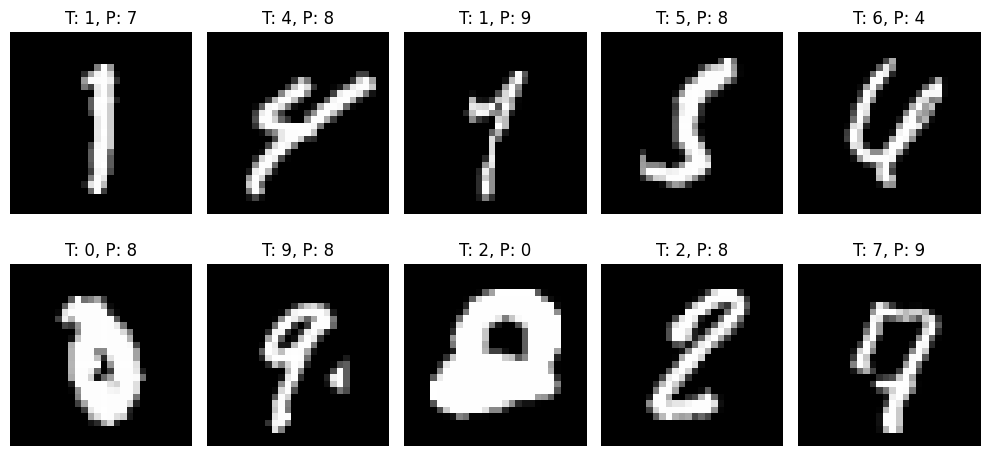

In [ ]:
misclassified = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        pred_classes = preds.argmax(dim=1)
        misclassified_idx = (pred_classes != y).nonzero(as_tuple=True)[0]
        misclassified.extend([(X[idx].cpu(), y[idx].item(), pred_classes[idx].item()) for idx in misclassified_idx])

# Plot a few misclassified samples
plt.figure(figsize=(10, 5))
for i, (img, true_label, pred_label) in enumerate(misclassified[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"T: {true_label}, P: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

3. Implement and execute the PGD attack on 1000 examples of the testing set. The hyperparameters of PGD are given below.
The perturbation is bounded by a maximum L-infinity norm, called epsilon (eps), which means that each pixel can be perturbed between -eps and +eps. We initialy set the maximum perturbation to eps = 32/255. For simplicity, you can set the step size alpha = epsilon / 10, and run PGD with only one random restart.

You can find the description of PGD in the paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083) and an example of another adversarial attack on the PyTorch documentation [https://pytorch.org/tutorials/beginner/fgsm_tutorial.html](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).
Tips: use the F.cross_entropy loss during the attack.


In [ ]:
n_examples = 1000
eps = 32/255
n_iter = 50
alpha = eps / 10

In [32]:
## YOUR CODE HERE: Generate adversarial examples


4. Show the robust accuracy of model_0, that is the accuracy of the model on the adversarial examples.

In [33]:
## YOUR CODE HERE: Evaluate model robust accuracy


5. Show the impact of the maximum perturbation allowed (denoted epsilon).

In [34]:
eps = [8/255, 16/255, 32/255, 64/255]
alpha = [e/10 for e in eps]

In [35]:
## YOUR CODE HERE: compute the adversarial examples for each provided epsilon
## (maximum l-infinity norm of the perturbation), and compute the associated robust accuracy
## Use a graph to display your result. You may use the [Matplotlib] (https://matplotlib.org/stable/index.html).

6. Using matplotlib, plot 10 adversarial examples, along with their corresponding original images. Choose one original image classified per class (the 10 class should be represented). For each image (adversarial and original), add on the plot the predicted class of the image.


In [36]:
## YOUR CODE HERE

**Question**: Please comment your results of this section.

**ANSWER HERE**


## 2. Transferability

In this section we will see how adversarial examples generated on one model can be adversarial on another model using a different architecture.
Let suppose a second model which parameters are unknown. For instance, it could be a model deploy on a cloud platform. We will use the examples generated in Section 1 on model_0 to fool this new model denoted model_1.
We say that model_0 is a surrogate for model_1.

1. Define a neural network architecture for MNIST different than the one used in Section 1.

In [37]:
## GIVEN
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

2. Train the neural network model_1 with the same hyperparameters as model_0


In [38]:
## YOUR CODE HERE
model_1 = None
optimizer = None  # create a new optimizer object when you train a new model

3. What is the ratio of successful adversarial examples on model_0 that transfers to model_1 (ie. that are also adversarial for model_1)?


In [39]:
model_1.eval()
## YOUR CODE HERE

AttributeError: 'NoneType' object has no attribute 'eval'

What do you conclude about the robustness of the model? Can [secrecy](https://en.wikipedia.org/wiki/Security_through_obscurity) defend a model?

**ANSWER HERE**

## 3. Use adversarial training to robustify the model

Adversarial training is a common method to robustify models to adversarial examples as described in this paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083). In this section you should update the training loop such that 3/4 of the batch is used for training while the remaining forth is first perturbed with PGD and then used for training. You can limit the number of iterations of PDG to 10. Use model_0 architecture from Section 1 in this section.

1. Train model_robust using adversarial training. You may want to run it for additional epoch (x2) to reach a similar clean accuracy.

In [ ]:
n_iter = 10  # less iterations to accelerate training. But once trained, we will still evaluate the robust accuracy on more iterations for a more powerful attack.
eps = 32/255
alpha = eps / 5
model_robust = Net()  # newly initialized NN

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    adv_size = int(batch_size/4)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size/batch_size)):

        # Generate adversarial examples for a forth of the data

        model.eval()
        ## YOUR CODE HERE
        model.train()

        # Compute prediction and loss

        ## YOUR CODE HERE:

        # Backpropagation

        ## YOUR CODE HERE:



In [ ]:
## YOUR CODE HERE: The rest of training implementation is unchanged.
## Do not reuse the same optimizer object!!!

2. Compare the robust accuracies of model_0 and model_robust using the same hyperparameters of PGD for different eps size, use a graph to show your results.

In [ ]:
n_examples = 1000
n_iter = 50
eps = [8/255, 16/255, 32/255, 64/255]
alpha = [e/10 for e in eps]

In [ ]:
## YOUR CODE HERE

**Questions**: Please comment your results. Does adversarial training appears to be a valid defense? Please develop threads to validity of the robust accuracy evaluation carried out here. What could be done to improve the evaluation of the robustness of the model?

**ANSWER HERE**